In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
x_train_full, x_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [3]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

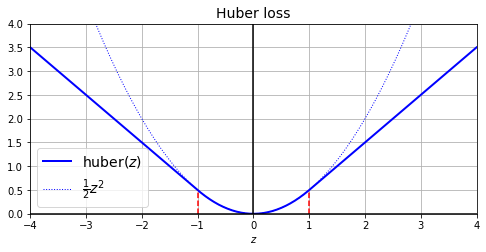

In [4]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [5]:
input_shape = x_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu', 
                       kernel_initializer='lecun_normal', 
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [6]:
model.compile(loss=huber_fn, optimizer='nadam', metrics=['mae'])

In [7]:
model.fit(x_train_scaled, y_train, epochs=2, 
          validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 936us/step - loss: 0.5526 - mae: 0.9044 - val_loss: 0.2034 - val_mae: 0.4920
Epoch 2/2
363/363 [==============================] - 0s 688us/step - loss: 0.2017 - mae: 0.4929 - val_loss: 0.1952 - val_mae: 0.4780


In [8]:
model.save('model_with_custom_loss.h5')

In [9]:
model = keras.models.load_model('model_with_custom_loss.h5', 
                                custom_objects={'huber_fn': huber_fn})

In [10]:
model.fit(x_train_scaled, y_train, epochs=2, 
          validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 0s 839us/step - loss: 0.1958 - mae: 0.4839 - val_loss: 0.1848 - val_mae: 0.4645
Epoch 2/2
363/363 [==============================] - 0s 674us/step - loss: 0.1920 - mae: 0.4780 - val_loss: 0.1802 - val_mae: 0.4568


In [11]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [12]:
model.compile(loss=create_huber(2.0), optimizer='nadam')

model.fit(x_train_scaled, y_train, epochs=2, 
          validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 788us/step - loss: 0.1747 - val_loss: 0.1788
Epoch 2/2
363/363 [==============================] - 0s 645us/step - loss: 0.1723 - val_loss: 0.1703


In [13]:
model.save('model_with_custom_loss_threshold_2.h5')

In [14]:
model = keras.models.load_model('model_with_custom_loss_threshold_2.h5', 
                                custom_objects={'huber_fn': create_huber(2.0)})

In [15]:
model.fit(x_train_scaled, y_train, epochs=2, 
          validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.1711 - val_loss: 0.1757
Epoch 2/2
363/363 [==============================] - 0s 682us/step - loss: 0.1701 - val_loss: 0.1658


In [16]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

In [17]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu', 
                       kernel_initializer='lecun_normal', 
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [18]:
model.compile(loss=HuberLoss(2.), optimizer='nadam', metrics=['mae'])

In [19]:
model.fit(x_train_scaled, y_train, epochs=2, 
          validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 939us/step - loss: 0.8830 - mae: 1.0174 - val_loss: 0.2934 - val_mae: 0.5456
Epoch 2/2
363/363 [==============================] - 0s 769us/step - loss: 0.2458 - mae: 0.5176 - val_loss: 0.2614 - val_mae: 0.5080


In [20]:
model.save('model_with_custom_loss_class.h5')

In [21]:
model = keras.models.load_model('model_with_custom_loss_class.h5', 
                                custom_objects={'HuberLoss': HuberLoss})

In [22]:
model.fit(x_train_scaled, y_train, epochs=2, 
          validation_data=(x_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 923us/step - loss: 0.2327 - mae: 0.5018 - val_loss: 0.2311 - val_mae: 0.4876
Epoch 2/2
363/363 [==============================] - 0s 761us/step - loss: 0.2262 - mae: 0.4945 - val_loss: 0.2121 - val_mae: 0.4740


In [23]:
model.loss.threshold

2.0